In [122]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

file_data   = "mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

#train data 정의
train_data= data[:1000]
num_train = len(train_data)

#test data 정의
test_data= data[1000:10000]
num_test = len(test_data)

#normalize func
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

size_row = 28
size_col = 28

list_train_image  = np.empty((size_row * size_col, num_train), dtype=float)
list_train_label  = np.empty(num_train, dtype=int)

list_test_image  = np.empty((size_row * size_col, num_test), dtype=float)
list_test_label  = np.empty(num_test, dtype=int)


#iteration parameter init
count1 = 0
count2 = 0

for line in train_data:

    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])
    im_vector   = normalize(im_vector)

    list_train_label[count1]       = label
    list_train_image[:, count1]    = im_vector

    count1 += 1
    
for line in test_data:
    
    line_data = line.split(',')
    label = line_data[0]
    im_vector =np.asfarray(line_data[1:])
    im_vector = normalize(im_vector)
    
    list_test_label[count2] = label
    list_test_image[:,count2] = im_vector
    
    count2 +=1




In [123]:
list_train_image = list_train_image.T
list_test_image = list_test_image.T

In [324]:
reg_lambda = 1
iterations = 100
alpha = 0.01
num_examples = len(list_train_image)

In [373]:
def sigmoid(z):
    return 1/ ( 1 + np.exp(-z) )
    
def sigmoid_der(x):
    return sigmoid(x)*(1-sigmoid(x))

def softmax(x):
    k=(np.exp(x)-np.max(x))
    return k/np.sum(k)
    


In [374]:
list_train_image.shape[1]

784

In [375]:
list_train_image[1]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [376]:
def build_wb(list_train_image,hidden_dim,output_dim):
    wb_model = {}
    input_dim = list_train_image.shape[1]
    wb_model['w1'] = np.random.randn(input_dim, hidden_dim) / np.sqrt(input_dim)
    wb_model['b1'] = np.zeros((1, hidden_dim))
    wb_model['w2'] = np.random.randn(hidden_dim, hidden_dim) / np.sqrt(hidden_dim)
    wb_model['b2'] = np.zeros((1, hidden_dim))
    wb_model['w3'] = np.random.randn(hidden_dim, output_dim) / np.sqrt(hidden_dim)
    wb_model['b3'] = np.zeros((1, output_dim))
    return wb_model 

In [377]:
def forward_prop(model,X):
    w1, b1, w2, b2, w3, b3 = model['w1'], model['b1'], model['w2'], model['b2'], model['w3'], model['b3']
    #forward_prop
    a1 = X.dot(w1) + b1
    z1 = sigmoid(a1)
    a2 = z1.dot(w2) + b2
    z2 = sigmoid(a2)
    a3 = z2.dot(w3) + b3
    output = Softmax(a3)
    return a1,z1,a2,z2,a3,output

In [378]:
def cal_loss(model,X,y,reg_lambda):
    num_examples = X.shape[0]
    w1, b1, w2, b2, w3, b3 = model['w1'], model['b1'], model['w2'], model['b2'], model['w3'], model['b3']
    # Forward propagation to calculate our predictions
    a1, z1, a2, z2, a3, output = forward_prop(model, X)
    probs = output / np.sum(output, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    loss += reg_lambda/2 * (np.sum(np.square(w1)) + np.sum(np.square(w2)) + np.sum(np.square(w3)))
    return 1.0 /num_examples * loss

In [379]:
def backprop(X,y,model,a1,z1,a2,z2,a3,output,reg_lambda):
    delta3 = output
    delta3[range(X.shape[0]), y] -= 1  #yhat - y
    dW3 = (z2.T).dot(delta3)
    db3 = np.sum(delta3, axis=0, keepdims=True)
    delta2 = delta3.dot(model['w3'].T) * sigmoid_der(z2)
    dW2 = np.dot(a1.T, delta2)
    db2 = np.sum(delta2, axis=0)
    #delta2 = delta3.dot(model['W2'].T) * (1 - np.power(a1, 2)) #if tanh
    delta1 = delta2.dot(model['w2'].T) * sigmoid_der(z1)
    dW1 = np.dot(X.T, delta1)
    db1 = np.sum(delta1, axis=0)
    # Add regularization terms
    dW3 += reg_lambda * model['w3']
    dW2 += reg_lambda * model['w2']
    dW1 += reg_lambda * model['w1']
    return dW1, dW2, dW3, db1, db2, db3


In [380]:
def testing(X, Y):
        # test the model on the training dataset
        total_correct = 0
        for n in range(len(X)):
            y = Y[n]
            x = X[n][:]
            prediction = np.argmax(forward_prop(x,y)['output'])
            if (prediction == y):
                total_correct += 1 
        print('Accuarcy Test: ',total_correct/len(X_test))
        return total_correct/np.float(len(X_test))

In [381]:
def train(model, X, y, iterations, reg_lambda, alpha):
    # Batch gradient descent
    done = False
    previous_loss = float('inf')
    i = 0
    losses = []
     #comment out while performance testing
    while i < iterations:
        #feed forward
        a1,z1,a2,z2,a3,output = forward_prop(model, X)
        #backpropagation
        dW1, dW2, dW3, db1, db2, db3 = backprop(X,y,model,a1,z1,a2,z2,a3,output,reg_lambda)
        #update weights and biases
        model['w1'] -= alpha * dW1
        model['b1'] -= alpha * db1
        model['w2'] -= alpha * dW2
        model['b2'] -= alpha * db2
        model['w3'] -= alpha * dW3
        model['b3'] -= alpha * db3
        
        loss = cal_loss(model, X, y, reg_lambda)
        losses.append(loss)
        #uncomment once testing finished, return mod val to 1000
        previous_loss = loss
        i += 1
    return model, losses

In [ ]:
#input_dim = 784
#output_dim = 10
wb_model = build_wb(list_train_image,100,10)
wb_model_t = build_wb(list_test_image,100,10)
wb_model , losses = train(wb_model,list_train_image,list_train_label,iterations,reg_lambda,alpha)
wb_model_t, losses_t = train(wb_model_t,list_test_image,list_test_label,iterations,reg_lambda,alpha)
output = forward_prop(wb_model,list_train_image)

C:\Users\ihbor\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


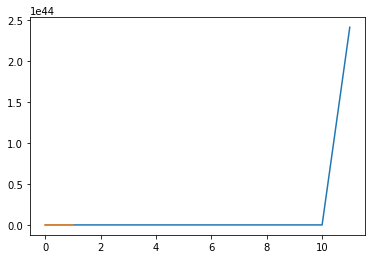

In [384]:
plt.plot(losses)
plt.plot(losses_t)